In [1]:
import glob
import librosa
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix
from sklearn.model_selection import LeaveOneOut, train_test_split, KFold
from sklearn.svm import SVC

from micromlgen import port

In [2]:
def format_dfs(file, n_splits):
    
    temp_df = pd.read_csv(file)
    split_size = int(len(temp_df)/n_splits)

    avg_dict = {}
    for col in temp_df:
        if col != "Block":
            avg_dict[col] = []

    for i in range(n_splits):
        j = i + 1
        new_df = temp_df.loc[(temp_df["Block"] >= i*split_size) & (temp_df["Block"] < (i+1)*split_size)]
        for col in new_df:
            if col != "Block":
                avg_dict[col].append(new_df[col].mean())

    return pd.DataFrame(avg_dict)

In [3]:
def run_models(df):

    # Prep features and target
    features = df.drop(columns=["Class"])
    feature_names = features.columns
    target = df.Class
    class_labels = np.unique(target)
    cv = LeaveOneOut()

    # SVM
    X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.33)
    svm = SVC(kernel="linear")
    svm = svm.fit(X_train, y_train)
    y_pred = svm.predict(X_test)
    print(f"Train/test split accuracy SVM: {accuracy_score(y_test, y_pred)*100:.2f}%")
    print()
    
    svm = SVC(kernel="linear")
    actual_class = []
    predicted_class = []
    
    for train_index, test_index in cv.split(features):

        # Splitting into training and testing
        X_train, X_test = features.take(train_index), features.take(test_index)
        y_train, y_test = target[train_index], target[test_index]

        svm = svm.fit(X_train, y_train)
        y_pred = svm.predict(X_test)

        actual_class.append(y_test.item())
        predicted_class.append(y_pred[0])

    print(f"SVM Accuracy: {accuracy_score(actual_class, predicted_class)*100:.2f}%")
    plot_confusion_matrix(actual_class, predicted_class, "SVM", class_labels)
    svm_feature_importance = abs(svm.coef_[0])
    plot_feature_importance(svm_feature_importance, feature_names, "SVM")

    # Random Forest
    X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.33)
    rf = RandomForestClassifier()
    rf = rf.fit(X_train, y_train)
    y_pred = rf.predict(X_test)
    print(f"Train/test split accuracy RF: {accuracy_score(y_test, y_pred)*100:.2f}%")
    print()
    
    rf = RandomForestClassifier()
    actual_class = []
    predicted_class = []
    
    for train_index, test_index in cv.split(features):
        
        # Splitting into training and testing
        X_train, X_test = features.take(train_index), features.take(test_index)
        y_train, y_test = target[train_index], target[test_index]

        rf.fit(X_train, y_train)
        y_pred = rf.predict(X_test)

        actual_class.append(y_test.item())
        predicted_class.append(y_pred[0])

    print(f"RF Accuracy: {accuracy_score(actual_class, predicted_class)*100:.2f}%")
    plot_confusion_matrix(actual_class, predicted_class, "Random Forest", class_labels)
    rf_feature_importance = rf.feature_importances_
    plot_feature_importance(rf_feature_importance, feature_names, "Random Forest")

    rf_c_code = port(rf)
    file_path = "Soheyl_MFCC_RF_model.c"
    with open(file_path, "w") as file:
        file.write(rf_c_code)

In [4]:
def plot_feature_importance(feature_importance, feature_names, model_name):
    
    # Sort features by importance
    sorted_idx = np.argsort(feature_importance)
    sorted_importance = feature_importance[sorted_idx]
    sorted_features = np.array(feature_names)[sorted_idx]

    # Create the bar chart
    plt.figure()
    plt.barh(sorted_features, sorted_importance, color='skyblue')
    plt.xlabel('Feature Importance')
    plt.title(f'Feature Importance for {model_name}')
    plt.show()

In [5]:
def plot_confusion_matrix(y_true, y_pred, model_name, class_labels):
    
    # Calculate confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    
    # Plot confusion matrix
    plt.figure()
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title(f'Confusion Matrix for {model_name} (MFCCs only)')
    plt.show()

Train/test split accuracy SVM: 85.71%

SVM Accuracy: 86.67%


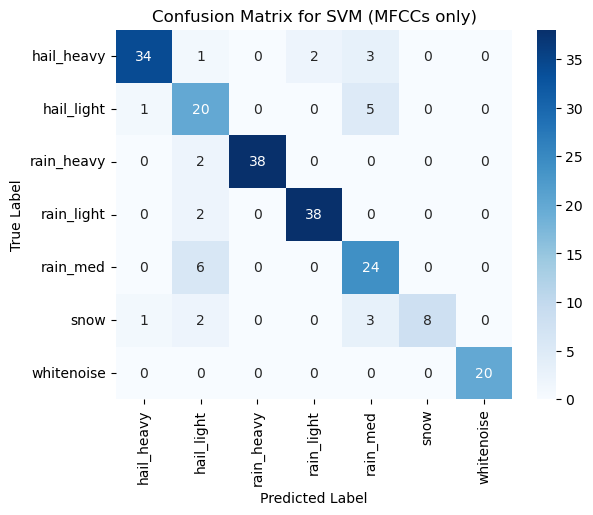

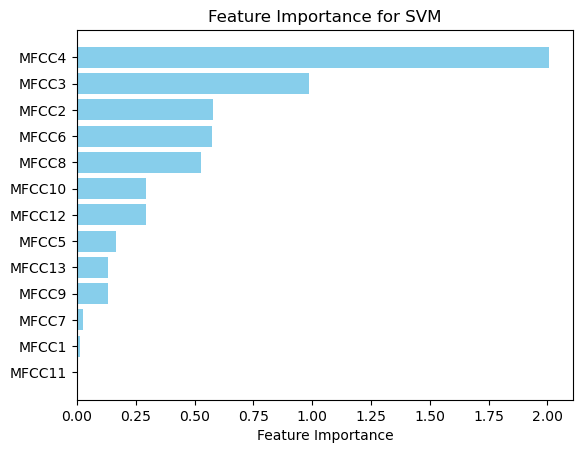

Train/test split accuracy RF: 85.71%

RF Accuracy: 86.67%


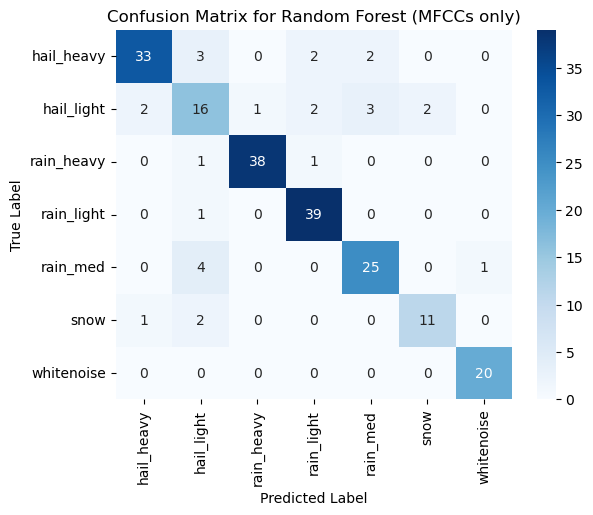

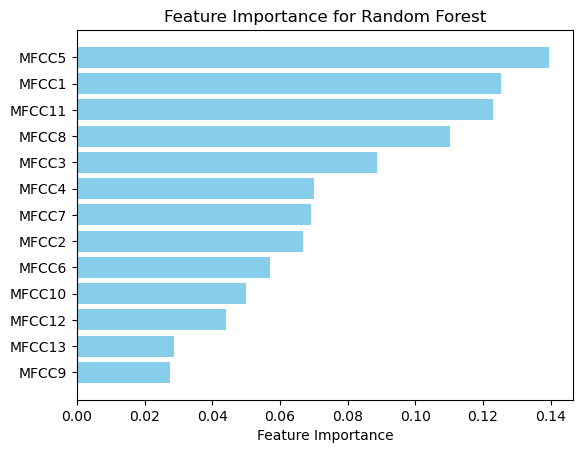

In [6]:
# Locate all audio files from new testing samples folder
all_csv_files = glob.glob("2Battery_MFCCs/*/*.CSV")

class_dict = {}
for file in all_csv_files:
    file_class = file.split('/')[1]
    if file_class not in class_dict:
        class_dict[file_class] = []
    class_dict[file_class].append(file)

all_class_dfs_list = []
n_splits = 2
for key in class_dict:
    for file in class_dict[key]:
        df = format_dfs(file, n_splits)
        df["Class"] = key
        all_class_dfs_list.append(df)

all_classes_df = pd.concat(all_class_dfs_list, ignore_index=True)
run_models(all_classes_df)

all_classes_df.to_csv("Soheyl_MFCC_Data.csv")